In [1]:
from sklearn.metrics import confusion_matrix, classification_report 
def scoreCalculator(predictor, attributes, labels):
    predicted = predictor.predict(attributes)
    errorScore = 0
    for guessIndex in range(len(predicted)):
        guess = predicted[guessIndex]
        actual = labels[guessIndex]
        if guess == 'hold' :
            errorScore += 0
        elif guess == 'long':
            if actual == 'short':
                errorScore += -15
            elif actual == 'hold':
                errorScore += -5
            else :#actual == 'long'
                errorScore += 20
        else: #short
            if actual == 'long':
                errorScore += -20
            elif actual == 'hold':
                errorScore += 0
            else: #actual == short
                errorScore += 20
    myMatrix = confusion_matrix(labels, predicted,normalize = 'all')     
    return  errorScore/len(predicted), myMatrix

In [2]:
from tabulate import tabulate
def catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer,sector):
    subIndustryIndex = 0
    counter = -1
    for col in sectorDF.columns: #finding indices for cat variables
        counter += 1
        if col == 'GICS Sub Industry':
            subIndustryIndex = counter
            break
    masterList = sectorDF.values
    catIndicies = [subIndustryIndex]
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList =\
    train_test_split(masterList,zScoreAnswer,fiveDayChangeAnswer,test_size = .3)

    trainPools = [Pool(data = masterTrainList, label = zScoreTrainList, cat_features = catIndicies),
    Pool(data = masterTrainList, label = fiveDayChangeTrainList, cat_features = catIndicies)]
    testPools = [Pool(data = masterTestList, label = zScoreTestList, cat_features = catIndicies),
    Pool(data = masterTestList, label = fiveDayChangeTestList, cat_features = catIndicies)]
    modelNames = ['ZScorePredictor','FiveDayPredictor']
    folderRoot = 'catPredictors/'
    accuracyList = []
    scoreList = []
    print('Catboost:')
    for name, train, test in zip(modelNames, trainPools, testPools):
        train.set_feature_names([x for x in sectorDF.columns])
        print(name)
        model = CatBoostClassifier()
        model.fit(train, eval_set = test, logging_level = 'Silent')
        sector = sector.replace(' ', '_')
        model.save_model(folderRoot + name + sector + '.mlmodel')
        accuracy =  model.score(test)
        print('Accuracy: ', accuracy)
        print(CatBoostClassifier.get_feature_importance(model, prettified = True))
        error, matrix = scoreCalculator(model, test,test.get_label())
        print('Error Score:', error)
        print('Confusion matrix:\n', matrix)
        accuracyList.append(accuracy)
        scoreList.append(error)
        
    averageAccuracy = sum([x for x in accuracyList])/len(accuracyList)
    averageScore = sum([x for x in scoreList])/len(scoreList)
    return averageAccuracy, averageScore

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import json
import os
from tabulate import tabulate

def sciKitPredictionMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer,sector):

    folderRoot = 'sciKitPredictors/'
    print('\nSci-Kit:')
    sectorDF.drop(columns = ['GICS Sub Industry'], inplace = True)
    masterList = sectorDF.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList =\
    train_test_split(masterList,zScoreAnswer,fiveDayChangeAnswer,test_size = .3)
    
    
    hyperParamDict = {'accuracy': 0,
    'error_score': -np.inf,
    'min_samples_split': 5,
    'min_impurity_decrease': 0}
    min_samples_splitChoices = [5,15,20,50,100, 200]
    min_impurity_decreaseChoices = [0, 0.00001,0.0001, 0.001, 0.01, 0.05, 0.1, 0.15]
    trainTestBundles = [['zScore', zScoreTrainList, zScoreTestList, hyperParamDict.copy()],
    ['fiveDay',fiveDayChangeTrainList, fiveDayChangeTestList, hyperParamDict.copy()]]

    for minSplit in min_samples_splitChoices:
        for minImpurity in min_impurity_decreaseChoices:
            for bundle in trainTestBundles:
                errorScoreList = []
                accuracyList = []
                for randState in range(3):
                    predictor = RandomForestClassifier(min_samples_split = minSplit, min_impurity_decrease = minImpurity,
                        random_state = randState, n_jobs = 2)
                    predictor.fit(masterTrainList, bundle[1])
                    predictions = predictor.predict(masterTestList)
                    predictionAccuracy = accuracy_score(bundle[2],predictions)
                    feature = pd.DataFrame(predictor.feature_importances_,
                                                        index = sectorDF.columns,
                                                        columns=['importance']).sort_values('importance', ascending=False)
                    errorScore, _ = scoreCalculator(predictor, masterTestList, zScoreTestList)
                    errorScoreList.append(errorScore)
                    accuracyList.append(predictionAccuracy)
                errorScore = sum(errorScoreList)/len(errorScoreList)
                predictionAccuracy = sum(accuracyList)/len(accuracyList)
                if errorScore > bundle[3]['error_score']:
                    bundle[3]['accuracy'] = predictionAccuracy
                    bundle[3]['error_score'] = errorScore
                    bundle[3]['min_samples_split'] = minSplit
                    bundle[3]['min_impurity_decrease'] = minImpurity
    print('Final result:')
    print(trainTestBundles[0][0], ' ', trainTestBundles[0][3])
    print(trainTestBundles[1][0], ' ',trainTestBundles[1][3])
    for bundle in trainTestBundles:
        print('bundle')
        predictor = RandomForestClassifier(min_samples_split = bundle[3]['min_samples_split'], 
        min_impurity_decrease = bundle[3]['min_impurity_decrease'], random_state = 1, n_jobs = 2)
        predictor.fit(masterTrainList, bundle[1])
        
        headers = ["name", "score"]
        values = sorted(zip(sectorDF.columns, predictor.feature_importances_), key=lambda x: x[1] * -1)
        print(tabulate(values, headers, tablefmt="plain"))
        
        _, matrix = scoreCalculator(predictor, masterTestList, zScoreTestList)
        print(bundle[0], ' confusion matrix\n',matrix)
        sector = sector.replace(' ', '_')
        pickle.dump(predictor, open(folderRoot + bundle[0] + sector + '.pkl', 'wb'))
    averageAccuracy = sum([trainTestBundles[x][3]['accuracy'] for x in range(len(trainTestBundles))])/len(trainTestBundles)
    averageScore = sum([trainTestBundles[x][3]['error_score'] for x in range(len(trainTestBundles))])/len(trainTestBundles)
    return averageAccuracy, averageScore

VolumeZScoreTenDay
highVsLowPerc
dayPercentChange
fiveVSTenDayWeightedAverage
fiveVsTenDaySlopeChange
fiveVsTenDayAverage
MACD
bPercent
rsi
zScoreOfChangeTmmrw
percentChangeInFiveDays
GICS Sector
GICS Sub Industry
thisDayZScore
totalVolumeOfTheDay
sent
sentChangeSinceYesterday
bPercentSent
DTWEXAFEGSValue
DTWEXAFEGSlastChangeP
DTWEXAFEGSfiveVsTenTickAverage
DTWEXAFEGSbPercent
DPRIMEValue
DPRIMElastChangeP
DPRIMEfiveVsTenTickAverage
DPRIMEbPercent
TOTCIValue
TOTCIlastChangeP
TOTCIfiveVsTenTickAverage
TOTCIbPercent
UNRATEValue
UNRATElastChangeP
UNRATEfiveVsTenTickAverage
UNRATEbPercent
CONSUMERValue
CONSUMERlastChangeP
CONSUMERfiveVsTenTickAverage
CONSUMERbPercent
BUSLOANSValue
BUSLOANSlastChangeP
BUSLOANSfiveVsTenTickAverage
BUSLOANSbPercent
CCLACBW027SBOGValue
CCLACBW027SBOGlastChangeP
CCLACBW027SBOGfiveVsTenTickAverage
CCLACBW027SBOGbPercent
STLFSI2Value
STLFSI2lastChangeP
STLFSI2fiveVsTenTickAverage
STLFSI2bPercent
PRS85006092Value
PRS85006092lastChangeP
PRS85006092fiveVsTenTickAvera

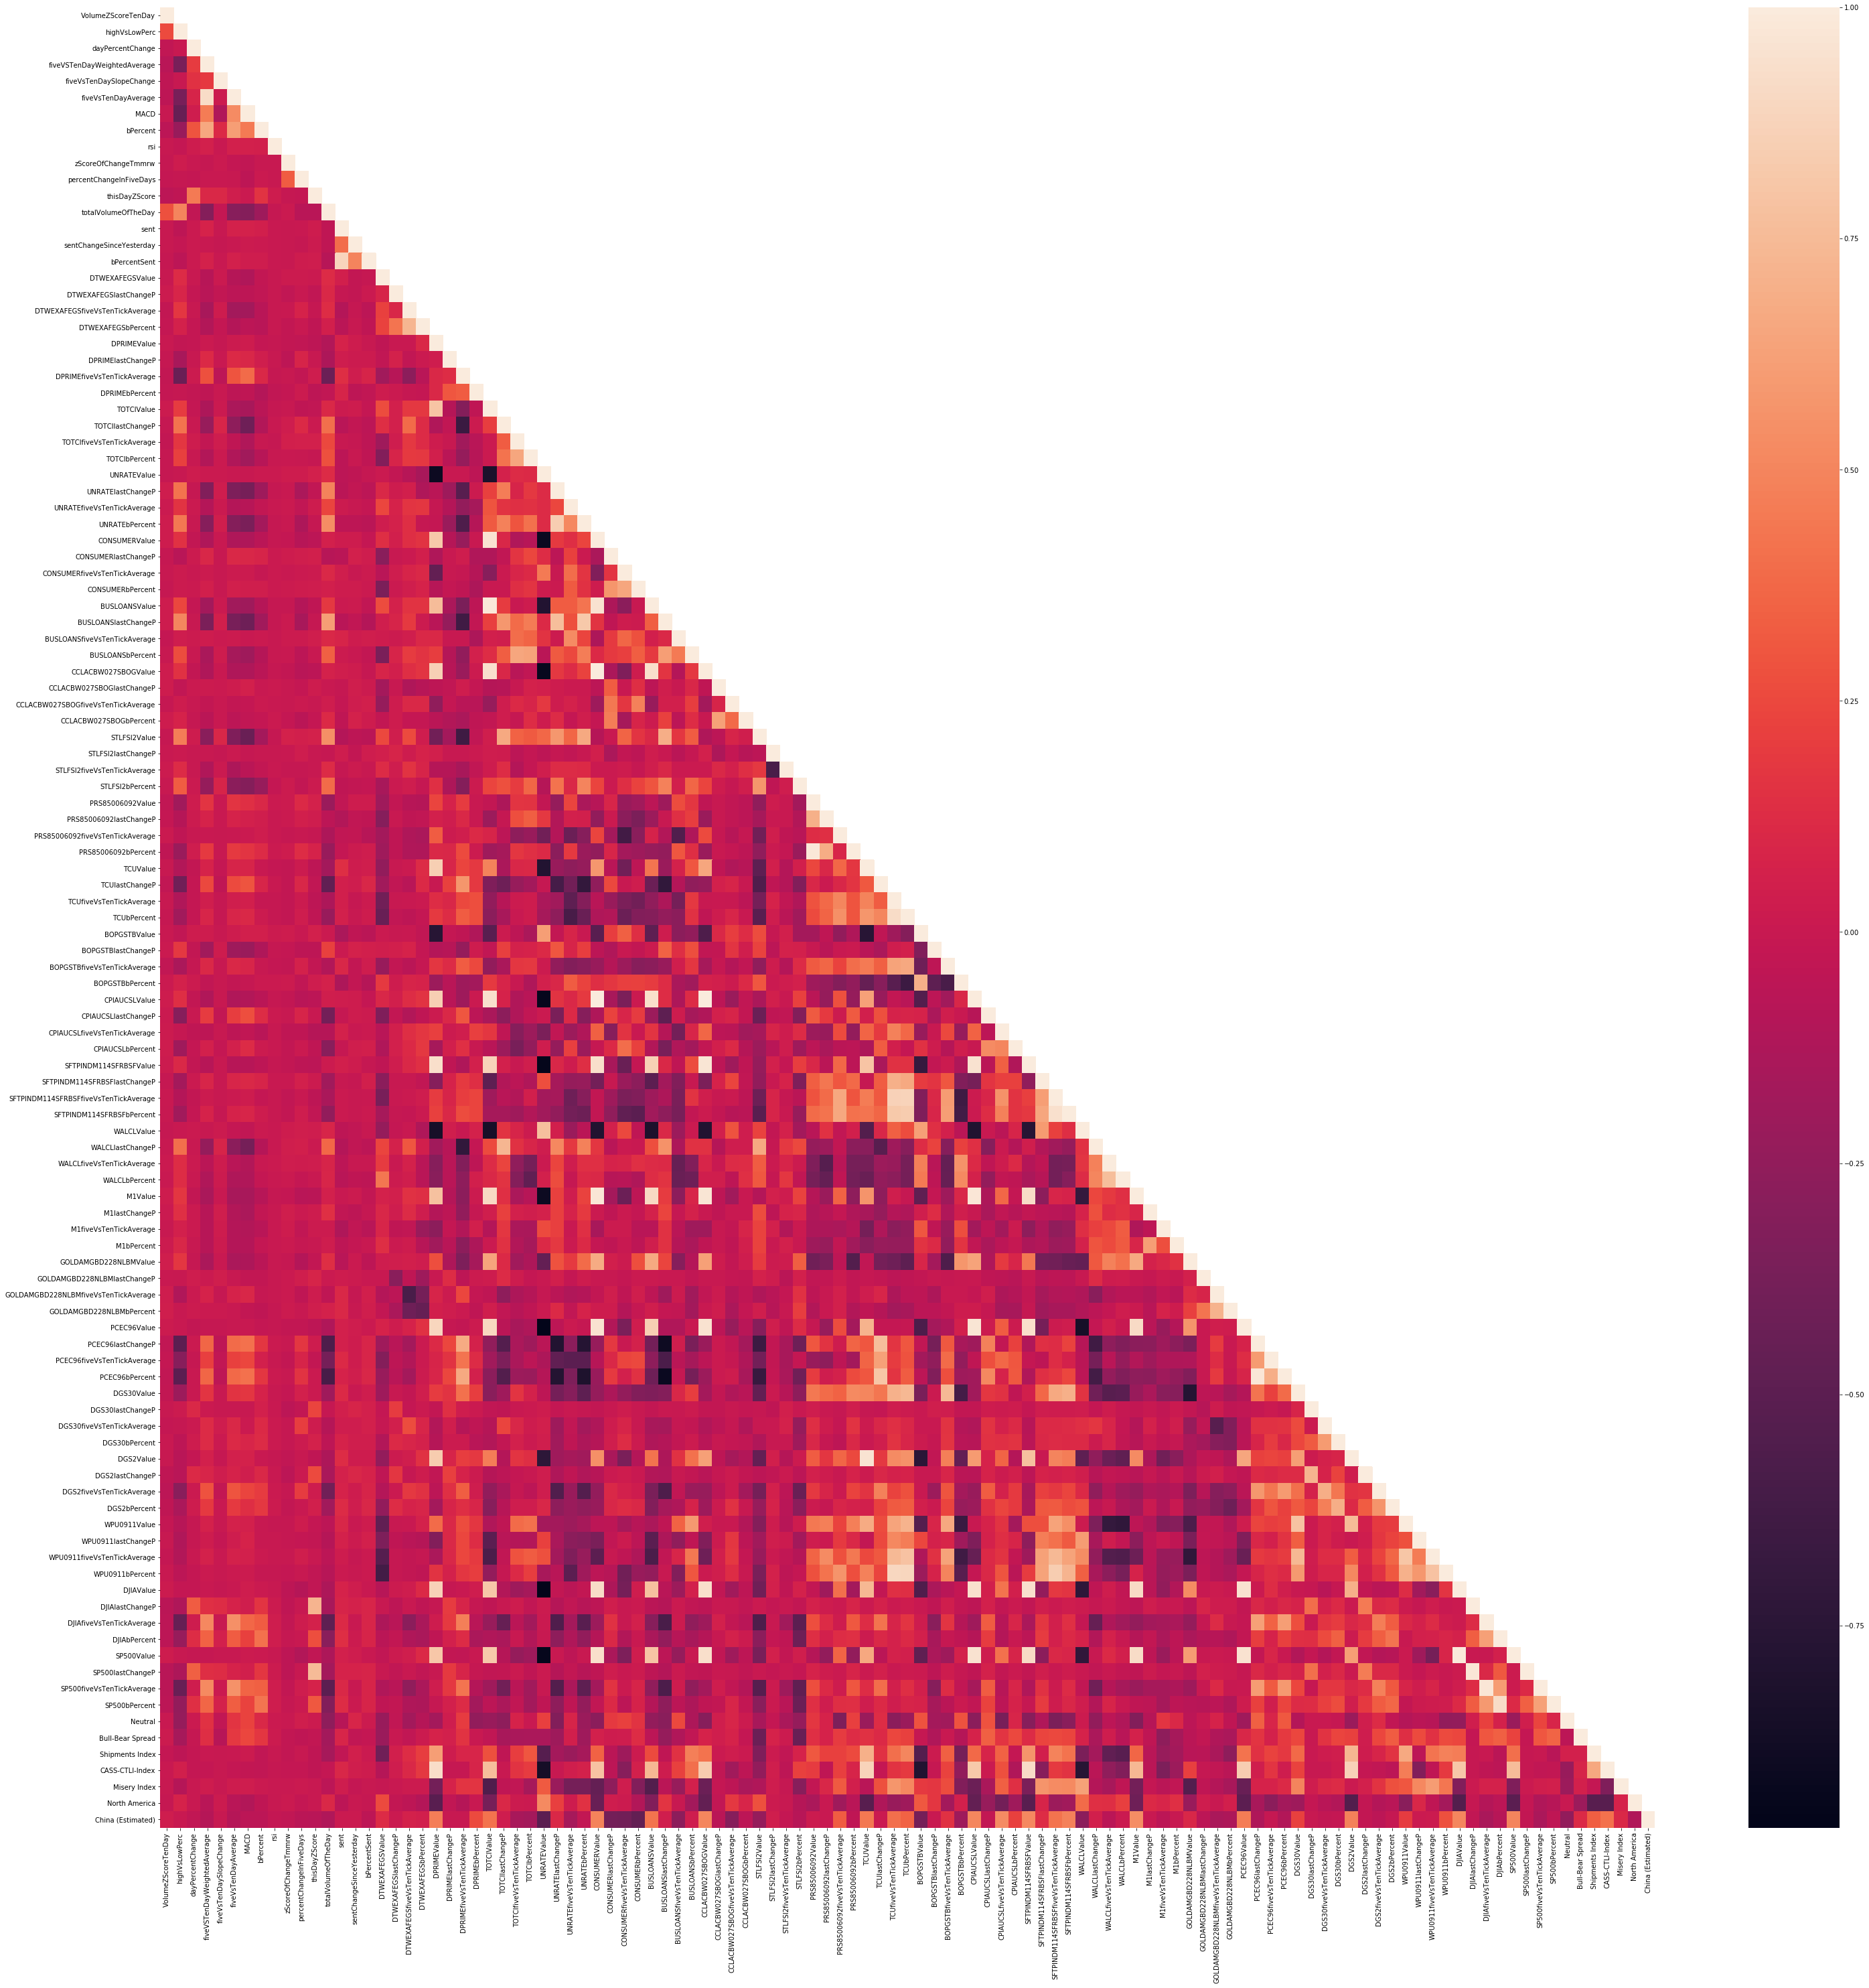

-------------------------------------------


Sector is:  Health Care
Catboost:
ZScorePredictor
Accuracy:  0.6012822020938713
                                Feature Id  Importances
0                            highVsLowPerc     3.235140
1              GOLDAMGBD228NLBMlastChangeP     3.065712
2                        GICS Sub Industry     2.670634
3                  fiveVsTenDaySlopeChange     2.481851
4                         DGS30lastChangeP     2.480148
5                       VolumeZScoreTenDay     2.449877
6                 sentChangeSinceYesterday     2.379224
7                                     MACD     2.270852
8                         dayPercentChange     2.270177
9                                     sent     2.209866
10                           thisDayZScore     2.148178
11                         DJIAlastChangeP     2.147713
12                            DGS2bPercent     2.094056
13                         DGS2lastChangeP     2.083170
14                                

Error Score: 5.788436654511234
Confusion matrix:
 [[0.25226444 0.09516527 0.0548759 ]
 [0.10387013 0.20874015 0.01970356]
 [0.08881308 0.02993765 0.14662981]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.5972826726267497, 'error_score': 3.662510292906717, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.5796769007567737, 'error_score': 1.5792259734148921, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0659405
VolumeZScoreTenDay                     0.0611847
dayPercentChange                       0.0603309
MACD                                   0.0599252
fiveVsTenDaySlopeChange                0.0587801
fiveVsTenDayAverage                    0.0585432
fiveVSTenDayWeightedAverage            0.0584068
bPercent                               0.0582383
rsi                                    0.0574995
totalVolumeOfTheDay                    0.0136964
DJI

fiveDay  confusion matrix
 [[0.237972   0.16715681 0.09122456]
 [0.09198918 0.12022115 0.04317139]
 [0.10169392 0.05887543 0.08769557]]
-------------------------------------------


Sector is:  Industrials
Catboost:
ZScorePredictor
Accuracy:  0.6233186057928326
                                Feature Id  Importances
0                            highVsLowPerc     2.964225
1                         DGS30lastChangeP     2.731544
2                 sentChangeSinceYesterday     2.695566
3                            thisDayZScore     2.673532
4                         dayPercentChange     2.654941
5                      totalVolumeOfTheDay     2.631189
6                       VolumeZScoreTenDay     2.629733
7                  fiveVsTenDaySlopeChange     2.539691
8                                     MACD     2.498177
9                          DGS2lastChangeP     2.267310
10             GOLDAMGBD228NLBMlastChangeP     2.235662
11                   DTWEXAFEGSlastChangeP     2.209883
12        

Error Score: 6.035100638193422
Confusion matrix:
 [[0.27501227 0.08217968 0.05257732]
 [0.10854197 0.20751105 0.01492391]
 [0.09027982 0.02243495 0.14653903]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.6163639338897071, 'error_score': 3.6360661102929144, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.6128129602356407, 'error_score': 1.2609229258713794, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0654788
dayPercentChange                       0.0606373
MACD                                   0.0600214
VolumeZScoreTenDay                     0.0597184
fiveVsTenDaySlopeChange                0.0594189
fiveVSTenDayWeightedAverage            0.0590158
fiveVsTenDayAverage                    0.0587402
rsi                                    0.0582296
bPercent                               0.0576481
totalVolumeOfTheDay                    0.0133354
DJ

fiveDay  confusion matrix
 [[0.26337752 0.15621011 0.0934217 ]
 [0.09931271 0.10510555 0.04104075]
 [0.10530191 0.05581738 0.08041237]]
-------------------------------------------


Sector is:  Consumer Discretionary
Catboost:
ZScorePredictor
Accuracy:  0.5708850361018635
                                Feature Id  Importances
0                            highVsLowPerc     3.626457
1                        GICS Sub Industry     3.236729
2              GOLDAMGBD228NLBMlastChangeP     3.100552
3                  fiveVsTenDaySlopeChange     2.903475
4                       VolumeZScoreTenDay     2.857941
5                                     MACD     2.711004
6                 sentChangeSinceYesterday     2.615326
7                         dayPercentChange     2.587477
8                         DGS30lastChangeP     2.571459
9                            thisDayZScore     2.282720
10                                     rsi     2.266316
11                            bPercentSent     2.138809

Error Score: 5.94924121233084
Confusion matrix:
 [[0.19520948 0.09399455 0.07306844]
 [0.0947728  0.20290544 0.03190799]
 [0.08902244 0.03951749 0.17960137]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.5659993946992953, 'error_score': 3.270929713058642, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.5506362863360571, 'error_score': 1.3687722484038796, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0778438
VolumeZScoreTenDay                     0.0721149
fiveVsTenDaySlopeChange                0.0717358
MACD                                   0.071585
dayPercentChange                       0.0712906
rsi                                    0.0708325
fiveVsTenDayAverage                    0.0704559
fiveVSTenDayWeightedAverage            0.070385
bPercent                               0.0703216
totalVolumeOfTheDay                    0.0104032
DJIAfiveVsTenT

fiveDay  confusion matrix
 [[0.20536988 0.1570323  0.12227074]
 [0.08124    0.11626097 0.05910329]
 [0.0936919  0.06628043 0.09875049]]
-------------------------------------------


Sector is:  Information Technology
Catboost:
ZScorePredictor
Accuracy:  0.6332309972475122
                                Feature Id  Importances
0                            highVsLowPerc     3.074913
1              GOLDAMGBD228NLBMlastChangeP     2.656978
2                            thisDayZScore     2.612805
3                         DGS30lastChangeP     2.607425
4                 sentChangeSinceYesterday     2.606951
5                  fiveVsTenDaySlopeChange     2.510136
6                      totalVolumeOfTheDay     2.470240
7                         dayPercentChange     2.412695
8                       VolumeZScoreTenDay     2.393634
9                                     MACD     2.271817
10                     fiveVsTenDayAverage     2.210077
11                        SP500lastChangeP     2.142461

Error Score: 6.5429811560448865
Confusion matrix:
 [[0.23671395 0.09871903 0.04890959]
 [0.10178912 0.24338344 0.01715012]
 [0.0789223  0.02789541 0.14651704]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.6328604700402286, 'error_score': 3.9614651704425157, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6010304185193027, 'error_score': 1.353130072693909, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0715618
dayPercentChange                       0.0663012
VolumeZScoreTenDay                     0.066006
fiveVSTenDayWeightedAverage            0.0657612
fiveVsTenDayAverage                    0.065437
MACD                                   0.0652743
fiveVsTenDaySlopeChange                0.0649511
rsi                                    0.063796
bPercent                               0.0635232
totalVolumeOfTheDay                    0.0116221
DJIAfiveVsTen

fiveDay  confusion matrix
 [[0.23925471 0.18547533 0.0926318 ]
 [0.08559178 0.1228033  0.04139318]
 [0.09056744 0.06293669 0.07934575]]
-------------------------------------------


Sector is:  Consumer Staples
Catboost:
ZScorePredictor
Accuracy:  0.5723214285714285
                                Feature Id  Importances
0                            highVsLowPerc     2.809874
1                 sentChangeSinceYesterday     2.802416
2                      totalVolumeOfTheDay     2.734822
3              GOLDAMGBD228NLBMlastChangeP     2.705984
4                         DGS30lastChangeP     2.674751
5                       VolumeZScoreTenDay     2.648196
6                            thisDayZScore     2.417797
7                        GICS Sub Industry     2.348716
8                  fiveVsTenDaySlopeChange     2.218632
9                         dayPercentChange     2.205277
10                        SP500lastChangeP     2.191080
11                   DTWEXAFEGSlastChangeP     2.185259
12   


Sci-Kit:
Final result:
zScore   {'accuracy': 0.5695436507936508, 'error_score': 3.700892857142857, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.5852513227513229, 'error_score': 1.2351190476190477, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0612955
VolumeZScoreTenDay                     0.0597653
MACD                                   0.058404
fiveVsTenDaySlopeChange                0.0581907
dayPercentChange                       0.0581288
fiveVsTenDayAverage                    0.0573576
fiveVSTenDayWeightedAverage            0.0568846
rsi                                    0.0568548
bPercent                               0.0561806
totalVolumeOfTheDay                    0.0132858
SP500lastChangeP                       0.0115747
thisDayZScore                          0.0111782
DJIAfiveVsTenTickAverage               0.011138
SP500bPercent        

fiveDay  confusion matrix
 [[0.3046627  0.1014881  0.07113095]
 [0.1360119  0.08472222 0.03343254]
 [0.15059524 0.04732143 0.07063492]]
-------------------------------------------


Sector is:  Utilities
Catboost:
ZScorePredictor
Accuracy:  0.6958259847148736
                                Feature Id  Importances
0                 sentChangeSinceYesterday     3.867070
1              GOLDAMGBD228NLBMlastChangeP     3.425568
2                    DTWEXAFEGSlastChangeP     3.088937
3                      totalVolumeOfTheDay     2.854415
4                         dayPercentChange     2.652904
5                            highVsLowPerc     2.652144
6                       VolumeZScoreTenDay     2.576303
7                  fiveVsTenDaySlopeChange     2.409836
8                            thisDayZScore     2.136133
9                                     MACD     2.126797
10                                    sent     2.110945
11                        DGS30lastChangeP     2.102031
12          


Sci-Kit:
Final result:
zScore   {'accuracy': 0.70915147952185, 'error_score': 6.117969821673526, 'min_samples_split': 15, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.7279639427787575, 'error_score': 1.7752302567117384, 'min_samples_split': 15, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0332292
dayPercentChange                       0.0294247
MACD                                   0.0282388
fiveVSTenDayWeightedAverage            0.0271669
fiveVsTenDayAverage                    0.0271308
bPercent                               0.0264204
rsi                                    0.0264084
fiveVsTenDaySlopeChange                0.0253909
VolumeZScoreTenDay                     0.0239819
totalVolumeOfTheDay                    0.0229894
GOLDAMGBD228NLBMlastChangeP            0.0199487
sentChangeSinceYesterday               0.0195762
SP500lastChangeP                       0.0186925
DTWEXAFEGSlastChang


Sector is:  Financials
Catboost:
ZScorePredictor
Accuracy:  0.6753147235905856
                                Feature Id  Importances
0                         DGS30lastChangeP     3.037017
1              GOLDAMGBD228NLBMlastChangeP     2.978019
2                 sentChangeSinceYesterday     2.758342
3                          DGS2lastChangeP     2.684383
4                            thisDayZScore     2.683785
5                            highVsLowPerc     2.572202
6                          DJIAlastChangeP     2.360328
7                         dayPercentChange     2.348724
8                                     MACD     2.272951
9                       VolumeZScoreTenDay     2.178189
10                 fiveVsTenDaySlopeChange     2.102648
11                   DTWEXAFEGSlastChangeP     2.091471
12                     totalVolumeOfTheDay     2.017452
13                            DGS2bPercent     1.979062
14          DTWEXAFEGSfiveVsTenTickAverage     1.887468
15                      

Error Score: 6.782430213464696
Confusion matrix:
 [[0.31056377 0.07197592 0.048659  ]
 [0.09370553 0.21357417 0.00826492]
 [0.08210181 0.01105638 0.16009852]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.674074074074074, 'error_score': 4.559569421638387, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6679255610290094, 'error_score': 1.4431673052362708, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0669626
MACD                                   0.0646256
dayPercentChange                       0.0643042
fiveVSTenDayWeightedAverage            0.0633613
fiveVsTenDaySlopeChange                0.0633211
bPercent                               0.0630696
fiveVsTenDayAverage                    0.0623363
rsi                                    0.0618888
VolumeZScoreTenDay                     0.0615534
totalVolumeOfTheDay                    0.0119553
SP500bPercen

fiveDay  confusion matrix
 [[0.2741653  0.1515052  0.10103996]
 [0.09660646 0.10372195 0.03847838]
 [0.10405036 0.04898741 0.08144499]]
-------------------------------------------


Sector is:  Real Estate
Catboost:
ZScorePredictor
Accuracy:  0.6544761904761904
                                Feature Id  Importances
0                 sentChangeSinceYesterday     3.505737
1                       VolumeZScoreTenDay     3.123081
2                    DTWEXAFEGSlastChangeP     3.020040
3              GOLDAMGBD228NLBMlastChangeP     2.952199
4                      totalVolumeOfTheDay     2.924149
5                         dayPercentChange     2.903866
6                            highVsLowPerc     2.880497
7                  fiveVsTenDaySlopeChange     2.597853
8                         DGS30lastChangeP     2.589929
9                                     MACD     2.561712
10                                     rsi     2.318754
11             fiveVSTenDayWeightedAverage     2.145645
12        


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6457989417989417, 'error_score': 4.56084656084656, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6358518518518519, 'error_score': 1.8074074074074076, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0567466
dayPercentChange                       0.0522118
MACD                                   0.0518294
fiveVSTenDayWeightedAverage            0.0513811
VolumeZScoreTenDay                     0.0511205
fiveVsTenDayAverage                    0.0510274
fiveVsTenDaySlopeChange                0.0504951
bPercent                               0.0504182
rsi                                    0.0497529
totalVolumeOfTheDay                    0.0157839
GOLDAMGBD228NLBMlastChangeP            0.0128277
DJIAlastChangeP                        0.0127113
thisDayZScore                          0.0126635
sentChangeSinceYesterday

-------------------------------------------


Sector is:  Materials
Catboost:
ZScorePredictor
Accuracy:  0.5916380297823597
                                Feature Id  Importances
0                            highVsLowPerc     3.689072
1                         dayPercentChange     3.273046
2                       VolumeZScoreTenDay     3.255969
3              GOLDAMGBD228NLBMlastChangeP     3.037133
4                          DGS2lastChangeP     2.938260
5                  fiveVsTenDaySlopeChange     2.833198
6                        GICS Sub Industry     2.604665
7                    DTWEXAFEGSlastChangeP     2.441836
8                         DGS30lastChangeP     2.372897
9                                      rsi     2.308897
10                            bPercentSent     2.212218
11                                    MACD     2.188095
12                     fiveVsTenDayAverage     2.166979
13                sentChangeSinceYesterday     2.073929
14                     totalVolumeOf


Sci-Kit:
Final result:
zScore   {'accuracy': 0.5932607865597556, 'error_score': 3.3364356624665903, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.5798014509354715, 'error_score': 1.163134784268805, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0620162
dayPercentChange                       0.0552358
VolumeZScoreTenDay                     0.0543545
MACD                                   0.0540737
fiveVsTenDaySlopeChange                0.0535243
rsi                                    0.0529414
fiveVsTenDayAverage                    0.0529306
fiveVSTenDayWeightedAverage            0.0526167
bPercent                               0.0517452
totalVolumeOfTheDay                    0.0135879
DGS2lastChangeP                        0.0123812
GOLDAMGBD228NLBMlastChangeP            0.0123268
DGS30lastChangeP                       0.0122674
sentChangeSinceYesterda

-------------------------------------------


Sector is:  Energy
Catboost:
ZScorePredictor
Accuracy:  0.6222692036645525
                                Feature Id  Importances
0                            highVsLowPerc     3.685902
1                            thisDayZScore     3.084788
2                         dayPercentChange     2.911089
3                       VolumeZScoreTenDay     2.868731
4                 sentChangeSinceYesterday     2.817359
5                    DTWEXAFEGSlastChangeP     2.597259
6                                     sent     2.461301
7                  fiveVsTenDaySlopeChange     2.447862
8                          DGS2lastChangeP     2.441290
9                                     MACD     2.437272
10                     totalVolumeOfTheDay     2.355741
11                                     rsi     2.334838
12                       GICS Sub Industry     2.252984
13             GOLDAMGBD228NLBMlastChangeP     2.190574
14          DTWEXAFEGSfiveVsTenTickAver


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6257256954931374, 'error_score': 5.2609147957985165, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6335783079969127, 'error_score': 2.5296150877546224, 'min_samples_split': 15, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0650025
dayPercentChange                       0.0586849
MACD                                   0.0581884
VolumeZScoreTenDay                     0.0570837
fiveVsTenDaySlopeChange                0.0567661
rsi                                    0.0563412
fiveVsTenDayAverage                    0.0562989
bPercent                               0.0562664
fiveVSTenDayWeightedAverage            0.0554258
totalVolumeOfTheDay                    0.0136767
thisDayZScore                          0.0122843
GOLDAMGBD228NLBMlastChangeP            0.0120066
SP500lastChangeP                       0.0117114
sent             

-------------------------------------------


Sector is:  Telecommunications Services
Catboost:
ZScorePredictor
Accuracy:  0.5238095238095238
                                Feature Id  Importances
0                            highVsLowPerc     4.561516
1                            thisDayZScore     3.735322
2                       VolumeZScoreTenDay     3.338921
3                 sentChangeSinceYesterday     2.792605
4                      totalVolumeOfTheDay     2.673447
5                             bPercentSent     2.651731
6                          DJIAlastChangeP     2.437454
7                         dayPercentChange     2.252359
8                    DTWEXAFEGSlastChangeP     2.163074
9                                 bPercent     2.115496
10                 fiveVsTenDaySlopeChange     2.052037
11                        DGS30lastChangeP     1.882937
12                                    sent     1.882771
13             fiveVSTenDayWeightedAverage     1.881625
14                

Final result:
zScore   {'accuracy': 0.5301587301587302, 'error_score': 2.6507936507936507, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6132275132275132, 'error_score': 1.6693121693121693, 'min_samples_split': 15, 'min_impurity_decrease': 0.0001}
bundle
name                                         score
highVsLowPerc                          0.0363535
VolumeZScoreTenDay                     0.0356044
dayPercentChange                       0.0315677
fiveVsTenDaySlopeChange                0.0301103
MACD                                   0.0299823
rsi                                    0.0294634
fiveVSTenDayWeightedAverage            0.0292458
bPercent                               0.02915
fiveVsTenDayAverage                    0.0279554
thisDayZScore                          0.0193866
sentChangeSinceYesterday               0.0183966
GOLDAMGBD228NLBMlastChangeP            0.0174511
totalVolumeOfTheDay                    0.0172237
DJIAlastChangeP             

In [4]:
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)


combinedDF = pd.read_csv('data/masterDF.csv', parse_dates = True)
combinedDF.drop(columns=['tmmrwChngAsPerc', 'Date', 'thisDayAveragePercentChange', 'thisDayPercentChangeStdev',
        'fiveDayWeightedAverage', 'tenDayWeightedAverage', 'fiveDaySlopeChange', 'tenDaySlopeChange', 
        'ticker', 'High', 'Low', 'Open', 'Close', 'Volume', 'fiveDayAverage', 'tenDayAverage', 'averageUp', 'averageDown'], inplace = True)
combinedDF.dropna(inplace = True)
for col in combinedDF.columns:
    print(col)
myBasicCorr = combinedDF.corr()
print(myBasicCorr['zScoreOfChangeTmmrw'].sort_values())
print(myBasicCorr['percentChangeInFiveDays'].sort_values())
plt.subplots(figsize=(50,50))
myBasicCorr = myBasicCorr.where(np.tril(np.ones(myBasicCorr.shape)).astype(np.bool))
sns.heatmap(myBasicCorr)
plt.show()

print('-------------------------------------------\n\n')
sectorList = combinedDF['GICS Sector'].copy().unique()
catAccuracy = []
catError = []
scikitAccuracy = []
scikitError = []
for sector in sectorList:
    print('Sector is: ', sector)
    sectorDF = combinedDF[combinedDF['GICS Sector'] == sector].copy()
    zScoreAnswer = sectorDF['zScoreOfChangeTmmrw']
    zScoreAnswer = zScoreAnswer.astype('float')
    zScoreAnswer = ['long' if x > .5 else 'short' if x < -.5 else 'hold' for x in zScoreAnswer ]
    fiveDayChangeAnswer = sectorDF['percentChangeInFiveDays']
    fiveDayChangeAnswer = ['long' if x > .015 else 'short' if x < -.015 else 'hold' for x in fiveDayChangeAnswer]
    
    sectorDF.drop(columns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'GICS Sector'], inplace = True)
    accuracy, error = catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector)
    catAccuracy.append(accuracy)
    catError.append(error)
    
    accuracy, error = sciKitPredictionMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector)
    scikitAccuracy.append(accuracy)
    scikitError.append(error)
    print('-------------------------------------------\n\n')
print('Catboost accuracy: ', mean(catAccuracy))
print('Catboost score: ' ,mean(catError))
print('Sci-kit accuracy: ', mean(scikitAccuracy))
print('Sci-kit score: ', mean(scikitError))